In [20]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [21]:
!python --version

Python 3.7.12


# Data Ingestion

## Load dataset training
### Memory optimization when loading the dataset

Since the dataset is very large, memory usage will be optimized when reading it with Pandas. By default, Pandas allocates data types like `int64`, `float64` or `object`, which can be unnecessarily heavy.

To reduce memory consumption:

- Numeric columns are **downcasted** to smaller types such as `int32`, `int8` or `float32`, whenever the range of values allows it.
- Categorical columns that Pandas would detect as `object` are forced to `category`, significantly reducing their size.

To apply this optimization, a **type dictionary (`dtype`)** will be used when reading the CSV with `pandas.read_csv`, specifying the type of each column.


In [22]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

dataset_df = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes, nrows=1_000_000)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1000000, 20)


## Load Labels
Load `train_labels.csv`, which contains for each session an indicator of whether the user answered each question correctly.  
These values constitute the **target variable** (or **labels/targets**) that the model must predict.


In [23]:
labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
labels.head(5)

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


The session id column contains both the session id and the question, marked by a q and the number. Let's split this column in two and add them to the dataframe.

In [24]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [25]:
labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


## Display answers to each question

First, the number of correct and incorrect answers will be plotted.

<AxesSubplot:>

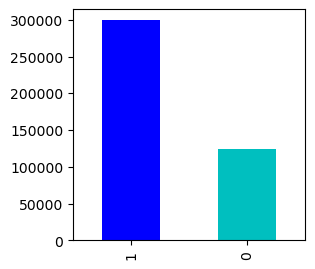

In [26]:
plt.figure(figsize=(3, 3))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

Subsequently, a graph will be made for each question, showing how many people answered correctly and how many did not.

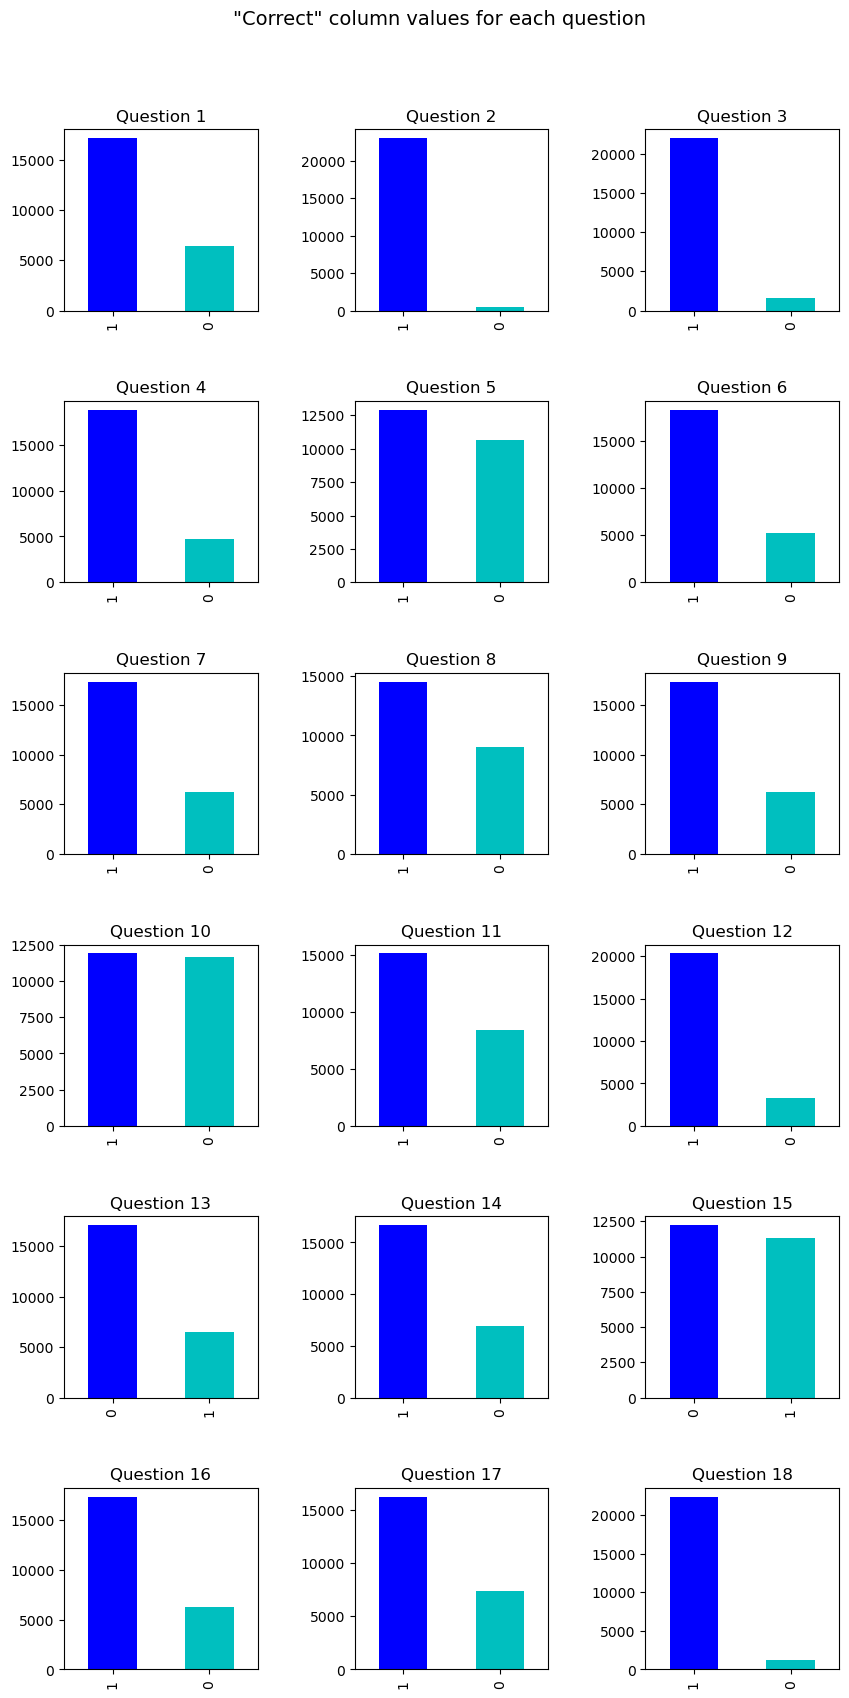

In [27]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)

for n in range(1,19):
    ax = plt.subplot(6, 3, n)

    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(kind="bar", color=['b', 'c'])

    ax.set_title("Question " + str(n))
    ax.set_xlabel("")

# Data Preparation

## Feature Engineering Setup

The dataset organizes user interactions into segments using the `level_group` column, which divides levels into three groups: `0-4`, `5-12`, and `13-22`.

Our objective is to predict whether each user answered each question in these level groups correctly.

To facilitate feature engineering, we define a dictionary called `FEATURE_SETS`. This dictionary includes multiple sets of features, where each set specifies:

- A list of **categorical columns** (used for frequency or uniqueness aggregations).
- A list of **numerical columns** (used for computing mean and standard deviation).
- A short **description** of the feature set’s focus.

These predefined feature set help us explore different modeling strategies based on various aspects of user interaction, such as interface configuration, text interaction, or screen behavior.

In [28]:
FEATURE_SETS = {
    1: {
        'categorical': ['event_name', 'name', 'fqid'],
        'numerical': ['elapsed_time', 'hover_duration', 'room_coor_x', 'room_coor_y'],
        'description': "Basic set with main user interactions"
    },
    2: {
        'categorical': ['fullscreen', 'hq', 'music', 'room_fqid'],
        'numerical': ['screen_coor_x', 'screen_coor_y', 'elapsed_time'],
        'description': "Set focused on user configuration settings"
    },
    3: {
        'categorical': ['event_name', 'fqid'],
        'numerical': ['elapsed_time'],
        'description': "Minimal set with only event-based features"
    },
    4: {
        'categorical': ['text', 'text_fqid'],
        'numerical': ['screen_coor_x', 'screen_coor_y', 'hover_duration'],
        'description': "Set focused on textual interaction features"
    }
}

### Function: `feature_engineer`

The `feature_engineer` function creates aggregated features from an interaction dataset grouped by `session_id` and `level_group`. For each categorical column provided, it calculates the number of unique values within each group. For each numerical column, it computes both the mean and standard deviation. These results are combined into a single DataFrame. Missing values are filled with -1, and the final dataset is indexed by `session_id`. The output is a feature-enriched dataset ready for modeling tasks.


We also split the dataset into a training dataset and a test dataset.

In [29]:
import sys
sys.path.append('/kaggle/input/modulesfiles')
from DataPreparation import feature_engineer, split_dataset

def prepare_all_datasets(dataset_df, feature_sets):
    datasets = {}
    train_x_sets = {}
    valid_x_sets = {}
    
    for set_id, features in feature_sets.items():
        try:
            missing_cols = [col for col in features['categorical'] + features['numerical'] 
                            if col not in dataset_df.columns]
            
            if missing_cols:
                print(f"Warning: Set {set_id} - Missing columns: {missing_cols}")
                continue
                
            # Data processing
            processed_data = feature_engineer(
                dataset_df, 
                features['categorical'],
                features['numerical']
            )
            
            train_x, valid_x = split_dataset(processed_data)
            
            # Store results
            datasets[set_id] = {
                'features': features,
                'processed_data': processed_data
            }
            train_x_sets[set_id] = train_x
            valid_x_sets[set_id] = valid_x
            
            print(f"Set {set_id} prepared: {features['description']}")
            
        except Exception as e:
            print(f"Error processing set {set_id}: {str(e)}")
    
    return datasets, train_x_sets, valid_x_sets

datasets, train_x_sets, valid_x_sets = prepare_all_datasets(dataset_df, FEATURE_SETS)

Set 1 prepared: Basic set with main user interactions
Set 2 prepared: Set focused on user configuration settings
Set 3 prepared: Minimal set with only event-based features
Set 4 prepared: Set focused on textual interaction features


In [30]:
# Display the first 5 examples
set_id = 1
dataset_df = pd.DataFrame(datasets[set_id]['processed_data'])
dataset_df.head(5)

,level_group,event_name_nunique,name_nunique,fqid_nunique,elapsed_time,hover_duration,room_coor_x,room_coor_y,elapsed_time_std,hover_duration_std,room_coor_x_std,room_coor_y_std
session_id,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,8.579356e+04,2389.500000,7.701275,-71.413750,49246.539458,3227.370757,399.296038,129.292411
20090312431273200,5-12,10,3,39,3.572052e+05,969.333313,14.306062,-57.269321,80175.676658,1316.408315,357.227701,137.409476
20090312431273200,13-22,10,3,49,1.040601e+06,899.925903,-130.347168,-162.004303,126666.129584,1305.088265,622.061374,230.370874
20090312433251036,0-4,11,4,22,9.763342e+04,1378.750000,-84.045959,-53.671082,67372.714092,2114.876406,445.980041,156.186242
20090312433251036,5-12,11,4,45,5.549040e+05,824.096802,50.284172,-53.836208,159319.587112,1836.236232,377.074056,160.557098


Let us plot some numerical columns and their value against each level_group:

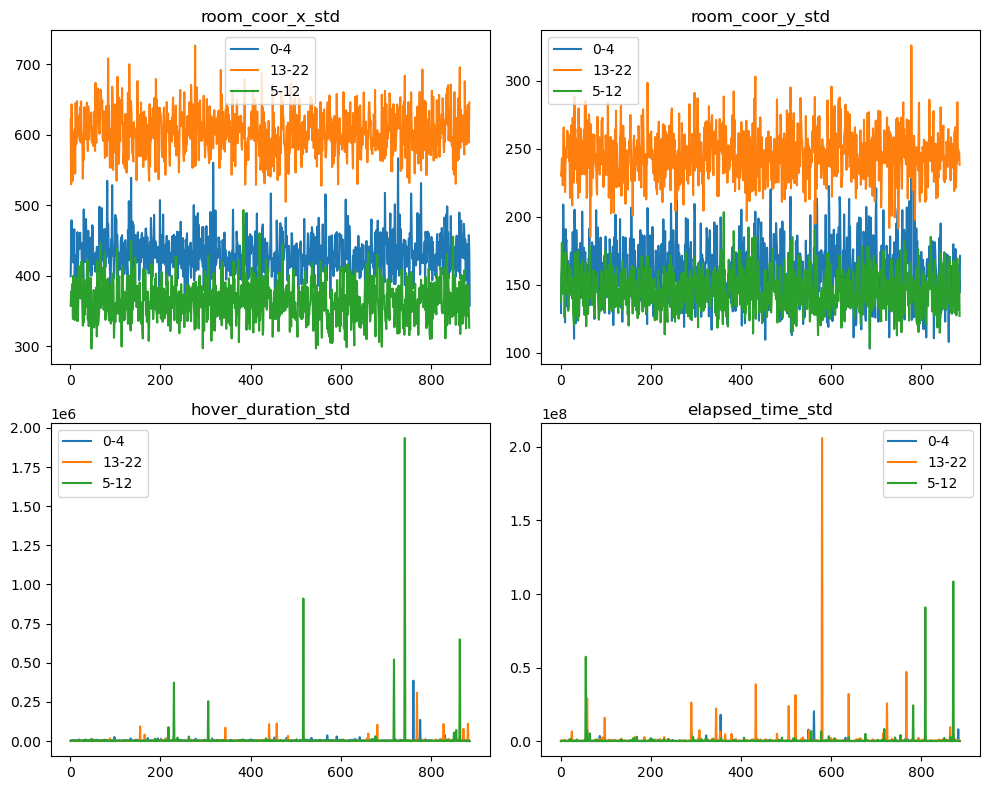

In [31]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(2, 2, figsize=(10, 8))

for name, data in dataset_df.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['hover_duration_std'])+1), data['hover_duration_std'], label=name)
    axis[1, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)


axis[0, 0].set_title('room_coor_x_std')
axis[0, 1].set_title('room_coor_y_std')
axis[1, 0].set_title('hover_duration_std')
axis[1, 1].set_title('elapsed_time_std')


for i in range(2):
    for j in range(2):
        axis[i, j].legend()

plt.tight_layout()  
plt.show()

# Select Model
We will use two tree-based machine learning models: Random Forest and XGBoost.



## Training
A model will be trained for each question in order to know if it will be answered correctly by a user. Each question will be modeled using the two aforementioned algorithms, combined with the four different feature sets. This results in a total of 8 evaluation metrics per question—one for each model-feature set combination.


### Understanding the Mapping Between Level Groups and Questions

Before training the models, it's important to clarify how quiz questions relate to level groups.

In the game, each `level_group` is followed by one or more quiz questions that assess user performance on that group of levels. The mapping is as follows:

- Questions 1 to 3 are based on interactions within level group 0–4
- Questions 4 to 13 correspond to level group 5–12
- Questions 14 to 18 correspond to level group 13–22

When training a model for a specific question, only the session data from its corresponding level group is used.

A separate model is trained for each question, and all models are stored in the `models` dictionary.



In [32]:
import sys
sys.path.append('/kaggle/input/modulesfiles') 

from DataPreparation import feature_engineer, split_dataset

from Models import XGBoostModel,ModelML,RandomForestTreeModel

def train_all_models(train_x_sets, valid_x_sets, labels):
    results = {}
    
    for set_id, train_x in train_x_sets.items():
        # Entrenar Random Forest
        rf_model = RandomForestTreeModel(valid_x_sets[set_id].index.unique())
        rf_models, rf_metrics = rf_model.train(train_x, valid_x_sets[set_id], labels)
        
        # Entrenar XGBoost
        xgb_model = XGBoostModel(valid_x_sets[set_id].index.unique())
        xgb_models, xgb_metrics = xgb_model.train(train_x, valid_x_sets[set_id], labels)
        
        results[set_id] = {
            'random_forest': {
                'models': rf_models,
                'metrics': rf_metrics
            },
            'xgboost': {
                'models': xgb_models,
                'metrics': xgb_metrics
            },
            'features': FEATURE_SETS[set_id]
        }
        
    
    return results

results = train_all_models(train_x_sets,valid_x_sets,labels)

[INFO 2025-07-11T18:03:23.038175449+00:00 kernel.cc:1214] Loading model from path /tmp/tmprtndke6t/model/ with prefix cc481820d3eb4973
[INFO 2025-07-11T18:03:23.041394908+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2025-07-11T18:03:23.041473861+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 45ms/step


[INFO 2025-07-11T18:03:23.891197712+00:00 kernel.cc:1214] Loading model from path /tmp/tmp4ftz7u1n/model/ with prefix 257a48644ff54fd0
[INFO 2025-07-11T18:03:23.893742954+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 47ms/step


[INFO 2025-07-11T18:03:24.792734585+00:00 kernel.cc:1214] Loading model from path /tmp/tmpt1_im35i/model/ with prefix 8226fd5fa332409d
[INFO 2025-07-11T18:03:24.796092764+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 46ms/step


[INFO 2025-07-11T18:03:25.704457128+00:00 kernel.cc:1214] Loading model from path /tmp/tmpjqhu0i0n/model/ with prefix 2144528beb554b85
[INFO 2025-07-11T18:03:25.708553854+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 50ms/step


[INFO 2025-07-11T18:03:27.485829671+00:00 kernel.cc:1214] Loading model from path /tmp/tmpozzgg1e1/model/ with prefix a8c4b38d042b4550
[INFO 2025-07-11T18:03:27.488401158+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 48ms/step


[INFO 2025-07-11T18:03:28.382711146+00:00 kernel.cc:1214] Loading model from path /tmp/tmpavardbcv/model/ with prefix 1229412880504947
[INFO 2025-07-11T18:03:28.384554872+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 48ms/step


[INFO 2025-07-11T18:03:29.336301688+00:00 kernel.cc:1214] Loading model from path /tmp/tmpd22ux7ax/model/ with prefix 45d56f82218e470d
[INFO 2025-07-11T18:03:29.340445291+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 45ms/step


[INFO 2025-07-11T18:03:30.285714782+00:00 kernel.cc:1214] Loading model from path /tmp/tmp5tibgyu_/model/ with prefix 064efdbe4c9847e6
[INFO 2025-07-11T18:03:30.288107102+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 45ms/step


[INFO 2025-07-11T18:03:31.222112363+00:00 kernel.cc:1214] Loading model from path /tmp/tmptixdy6on/model/ with prefix c9ea64dbb06a452a
[INFO 2025-07-11T18:03:31.225746518+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 47ms/step


[INFO 2025-07-11T18:03:32.270883715+00:00 kernel.cc:1214] Loading model from path /tmp/tmpt1rdubjj/model/ with prefix 37c1cd545b754950
[INFO 2025-07-11T18:03:32.274875032+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 48ms/step


[INFO 2025-07-11T18:03:33.363299259+00:00 kernel.cc:1214] Loading model from path /tmp/tmp6yznd1wc/model/ with prefix 3a3924cc9ea841a7
[INFO 2025-07-11T18:03:33.370628775+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2025-07-11T18:03:33.370673001+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 49ms/step


[INFO 2025-07-11T18:03:34.311730092+00:00 kernel.cc:1214] Loading model from path /tmp/tmp2aqvjjc2/model/ with prefix fd87af121cb94ec1
[INFO 2025-07-11T18:03:34.315435336+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 47ms/step


[INFO 2025-07-11T18:03:35.287647316+00:00 kernel.cc:1214] Loading model from path /tmp/tmpn13bnj63/model/ with prefix 285de89f474e46ac
[INFO 2025-07-11T18:03:35.292167774+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 46ms/step


[INFO 2025-07-11T18:03:36.206754524+00:00 kernel.cc:1214] Loading model from path /tmp/tmpy8s71uiu/model/ with prefix afc7c8b5f537454a
[INFO 2025-07-11T18:03:36.208827296+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 45ms/step


[INFO 2025-07-11T18:03:37.086392093+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0qvpe1tk/model/ with prefix be99d47c491f43b6
[INFO 2025-07-11T18:03:37.088988956+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:37.938425937+00:00 kernel.cc:1214] Loading model from path /tmp/tmpaz0yzre7/model/ with prefix 1bb7be279aab48e9
[INFO 2025-07-11T18:03:37.94066519+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:38.770543822+00:00 kernel.cc:1214] Loading model from path /tmp/tmpdqn0bylf/model/ with prefix 2ee0cf9fa4fc4b49
[INFO 2025-07-11T18:03:38.772596646+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:39.604105257+00:00 kernel.cc:1214] Loading model from path /tmp/tmpm_1efe3f/model/ with prefix 292310f87062499c
[INFO 2025-07-11T18:03:39.605836052+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 46ms/step


[INFO 2025-07-11T18:03:46.709876797+00:00 kernel.cc:1214] Loading model from path /tmp/tmpph3cgb3h/model/ with prefix 7fc805e46bcf46cf
[INFO 2025-07-11T18:03:46.714517913+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2025-07-11T18:03:46.714564753+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 53ms/step


[INFO 2025-07-11T18:03:47.640856228+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_yxjwu3e/model/ with prefix 918a15e03d2b43b6
[INFO 2025-07-11T18:03:47.642379156+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 46ms/step


[INFO 2025-07-11T18:03:48.675961542+00:00 kernel.cc:1214] Loading model from path /tmp/tmpsoq28re_/model/ with prefix ca6cce50e7764ba4
[INFO 2025-07-11T18:03:48.68039889+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:49.659396322+00:00 kernel.cc:1214] Loading model from path /tmp/tmpa12zzh6r/model/ with prefix e6f82244c05845cb
[INFO 2025-07-11T18:03:49.666691078+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:50.531091596+00:00 kernel.cc:1214] Loading model from path /tmp/tmpblqb7op3/model/ with prefix 0e40b1c8c2bf4c83
[INFO 2025-07-11T18:03:50.533178828+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:51.426742949+00:00 kernel.cc:1214] Loading model from path /tmp/tmpandqssci/model/ with prefix f32a0c26eed34a3f
[INFO 2025-07-11T18:03:51.431315986+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:52.304753579+00:00 kernel.cc:1214] Loading model from path /tmp/tmppi6m26eh/model/ with prefix cfd63a6653c44b81
[INFO 2025-07-11T18:03:52.30765326+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:53.159575373+00:00 kernel.cc:1214] Loading model from path /tmp/tmpthgfvqzf/model/ with prefix c07572823bce4ba7
[INFO 2025-07-11T18:03:53.161376878+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:54.027667602+00:00 kernel.cc:1214] Loading model from path /tmp/tmprgtt0kga/model/ with prefix 172a037838a840b2
[INFO 2025-07-11T18:03:54.030449465+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 44ms/step


[INFO 2025-07-11T18:03:55.043008515+00:00 kernel.cc:1214] Loading model from path /tmp/tmpt5tbamf6/model/ with prefix 15147f5daa424beb
[INFO 2025-07-11T18:03:55.048699603+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 45ms/step


[INFO 2025-07-11T18:03:55.910329218+00:00 kernel.cc:1214] Loading model from path /tmp/tmp8jyaa6wu/model/ with prefix 98656d4ee7444d23
[INFO 2025-07-11T18:03:55.913543867+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 42ms/step


[INFO 2025-07-11T18:03:56.789721524+00:00 kernel.cc:1214] Loading model from path /tmp/tmppf75q6_6/model/ with prefix e7bb342d24bd4dc1
[INFO 2025-07-11T18:03:56.791804396+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2025-07-11T18:03:56.791845776+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 46ms/step


[INFO 2025-07-11T18:03:57.68799722+00:00 kernel.cc:1214] Loading model from path /tmp/tmp02v932qw/model/ with prefix b8445a6271f34bb1
[INFO 2025-07-11T18:03:57.690360848+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 46ms/step


[INFO 2025-07-11T18:03:58.677185487+00:00 kernel.cc:1214] Loading model from path /tmp/tmpikfqx8gf/model/ with prefix df862d98a719493e
[INFO 2025-07-11T18:03:58.683256167+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 49ms/step


[INFO 2025-07-11T18:03:59.567202255+00:00 kernel.cc:1214] Loading model from path /tmp/tmp89bhszn3/model/ with prefix b02d8ee7e76842c7
[INFO 2025-07-11T18:03:59.569741128+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 45ms/step


[INFO 2025-07-11T18:04:00.491367568+00:00 kernel.cc:1214] Loading model from path /tmp/tmpn07j0rsi/model/ with prefix acfbe5c53022401e
[INFO 2025-07-11T18:04:00.493668623+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 46ms/step


[INFO 2025-07-11T18:04:01.371408375+00:00 kernel.cc:1214] Loading model from path /tmp/tmpf0cq79pb/model/ with prefix 56e79afe5f4f4789
[INFO 2025-07-11T18:04:01.373683459+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 47ms/step


[INFO 2025-07-11T18:04:02.438908922+00:00 kernel.cc:1214] Loading model from path /tmp/tmpfc8de7gx/model/ with prefix 0da4508d3a274d92
[INFO 2025-07-11T18:04:02.443318817+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 58ms/step


[INFO 2025-07-11T18:04:09.494328097+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_4qzcn1f/model/ with prefix 46d195b538e14499
[INFO 2025-07-11T18:04:09.496705441+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2025-07-11T18:04:09.496742728+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 38ms/step


[INFO 2025-07-11T18:04:10.132178472+00:00 kernel.cc:1214] Loading model from path /tmp/tmpo5r59vuf/model/ with prefix 98857604f7a745e7
[INFO 2025-07-11T18:04:10.133773058+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 37ms/step


[INFO 2025-07-11T18:04:10.778076537+00:00 kernel.cc:1214] Loading model from path /tmp/tmp8j9miebu/model/ with prefix 754d05f1d0d649b9
[INFO 2025-07-11T18:04:10.780063259+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 40ms/step


[INFO 2025-07-11T18:04:11.41566209+00:00 kernel.cc:1214] Loading model from path /tmp/tmpiw_4p_qq/model/ with prefix e3a0c621dc944406
[INFO 2025-07-11T18:04:11.417334836+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 37ms/step


[INFO 2025-07-11T18:04:12.711036928+00:00 kernel.cc:1214] Loading model from path /tmp/tmponhv4nl8/model/ with prefix c71aea65381d4ff1
[INFO 2025-07-11T18:04:12.714305029+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 39ms/step


[INFO 2025-07-11T18:04:13.359255878+00:00 kernel.cc:1214] Loading model from path /tmp/tmpv9x3uv3b/model/ with prefix 5f9b857fe80b43c9
[INFO 2025-07-11T18:04:13.361513916+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 36ms/step


[INFO 2025-07-11T18:04:14.002590484+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbwg3b8k8/model/ with prefix ffe9210f4a2b4555
[INFO 2025-07-11T18:04:14.004813719+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 36ms/step


[INFO 2025-07-11T18:04:14.662032261+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0832gh7s/model/ with prefix a4204806583042c1
[INFO 2025-07-11T18:04:14.666604114+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 58ms/step


[INFO 2025-07-11T18:04:15.333313878+00:00 kernel.cc:1214] Loading model from path /tmp/tmpe_u6cmuf/model/ with prefix ec9f4b55330c447d
[INFO 2025-07-11T18:04:15.335129174+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 38ms/step


[INFO 2025-07-11T18:04:15.96702956+00:00 kernel.cc:1214] Loading model from path /tmp/tmp421qnfpa/model/ with prefix 0db268d45af44ec1
[INFO 2025-07-11T18:04:15.969146635+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 36ms/step


[INFO 2025-07-11T18:04:16.60887023+00:00 kernel.cc:1214] Loading model from path /tmp/tmppmw2fe2y/model/ with prefix 687e7e2562654046
[INFO 2025-07-11T18:04:16.61219968+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 39ms/step


[INFO 2025-07-11T18:04:17.248545515+00:00 kernel.cc:1214] Loading model from path /tmp/tmpeyq_6197/model/ with prefix 5c6b5ec0e0fa4845
[INFO 2025-07-11T18:04:17.250365244+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 38ms/step


[INFO 2025-07-11T18:04:17.881004456+00:00 kernel.cc:1214] Loading model from path /tmp/tmpb00_x9hv/model/ with prefix d7a6212b42094d0c
[INFO 2025-07-11T18:04:17.882958818+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 37ms/step


[INFO 2025-07-11T18:04:18.589053124+00:00 kernel.cc:1214] Loading model from path /tmp/tmphf2vsh6w/model/ with prefix 4f94c7a27b2c4bb3
[INFO 2025-07-11T18:04:18.597141253+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 38ms/step


[INFO 2025-07-11T18:04:19.237645095+00:00 kernel.cc:1214] Loading model from path /tmp/tmpx122uov6/model/ with prefix e2195134406f4274
[INFO 2025-07-11T18:04:19.240624656+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 35ms/step


[INFO 2025-07-11T18:04:19.85464423+00:00 kernel.cc:1214] Loading model from path /tmp/tmpyoq3i7ye/model/ with prefix 08d1a8fe99174ced
[INFO 2025-07-11T18:04:19.856346109+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2025-07-11T18:04:19.856383611+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 36ms/step


[INFO 2025-07-11T18:04:20.535308509+00:00 kernel.cc:1214] Loading model from path /tmp/tmp4qktxyft/model/ with prefix dcfca5bbb22a40fc
[INFO 2025-07-11T18:04:20.542171398+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 36ms/step


[INFO 2025-07-11T18:04:21.167675693+00:00 kernel.cc:1214] Loading model from path /tmp/tmp1govt3sx/model/ with prefix a784fce3ffd94110
[INFO 2025-07-11T18:04:21.169632566+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 36ms/step


[INFO 2025-07-11T18:04:27.204041629+00:00 kernel.cc:1214] Loading model from path /tmp/tmpvnz0qkq7/model/ with prefix 00764feff0ba439a
[INFO 2025-07-11T18:04:27.207431511+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 43ms/step


[INFO 2025-07-11T18:04:27.946991904+00:00 kernel.cc:1214] Loading model from path /tmp/tmpaidme9j2/model/ with prefix 6156fba0d56d437c
[INFO 2025-07-11T18:04:27.948666894+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 39ms/step


[INFO 2025-07-11T18:04:28.685532478+00:00 kernel.cc:1214] Loading model from path /tmp/tmpjr5ax4k5/model/ with prefix c606ba379cbb44c8
[INFO 2025-07-11T18:04:28.688112715+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 41ms/step


[INFO 2025-07-11T18:04:29.478402978+00:00 kernel.cc:1214] Loading model from path /tmp/tmp5s5h4uat/model/ with prefix c52f789d1e5547c8
[INFO 2025-07-11T18:04:29.483289922+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 40ms/step


[INFO 2025-07-11T18:04:30.263730364+00:00 kernel.cc:1214] Loading model from path /tmp/tmpqk5ripbl/model/ with prefix a7a6125858794805
[INFO 2025-07-11T18:04:30.26560147+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2025-07-11T18:04:30.265638671+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 40ms/step


[INFO 2025-07-11T18:04:31.027997907+00:00 kernel.cc:1214] Loading model from path /tmp/tmpyoex8ux2/model/ with prefix 6ff4caf895bc40a0
[INFO 2025-07-11T18:04:31.030808191+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 40ms/step


[INFO 2025-07-11T18:04:31.807410681+00:00 kernel.cc:1214] Loading model from path /tmp/tmpfyxpyb_r/model/ with prefix 9469f70f5fbc4b78
[INFO 2025-07-11T18:04:31.811543691+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 49ms/step


[INFO 2025-07-11T18:04:32.596799891+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgkvzs3_l/model/ with prefix c924d36feba740b2
[INFO 2025-07-11T18:04:32.598846702+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 40ms/step


[INFO 2025-07-11T18:04:33.375998164+00:00 kernel.cc:1214] Loading model from path /tmp/tmpu2mrxmdw/model/ with prefix e5725f3038d64f28
[INFO 2025-07-11T18:04:33.378905144+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 46ms/step


[INFO 2025-07-11T18:04:34.217821111+00:00 kernel.cc:1214] Loading model from path /tmp/tmp7hm4iesf/model/ with prefix a8f02a149bd5406d
[INFO 2025-07-11T18:04:34.222257264+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 40ms/step


[INFO 2025-07-11T18:04:35.0843885+00:00 kernel.cc:1214] Loading model from path /tmp/tmpa1f6dyj9/model/ with prefix a08f9de6aa304ad5
[INFO 2025-07-11T18:04:35.087733326+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 39ms/step


[INFO 2025-07-11T18:04:35.859159153+00:00 kernel.cc:1214] Loading model from path /tmp/tmptfrz9zm8/model/ with prefix 1e1f5a904d5f46f9
[INFO 2025-07-11T18:04:35.86264409+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 41ms/step


[INFO 2025-07-11T18:04:36.618996273+00:00 kernel.cc:1214] Loading model from path /tmp/tmp7dd1rcat/model/ with prefix d60375934bda47e0
[INFO 2025-07-11T18:04:36.621028675+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 39ms/step


[INFO 2025-07-11T18:04:37.422542493+00:00 kernel.cc:1214] Loading model from path /tmp/tmp5pl3dnac/model/ with prefix 7b8ec44c0e4a480e
[INFO 2025-07-11T18:04:37.427622797+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 41ms/step


[INFO 2025-07-11T18:04:38.186915282+00:00 kernel.cc:1214] Loading model from path /tmp/tmp00zmqy5g/model/ with prefix 63beca185fde41f8
[INFO 2025-07-11T18:04:38.189405984+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 41ms/step


[INFO 2025-07-11T18:04:39.040796936+00:00 kernel.cc:1214] Loading model from path /tmp/tmpwfj7y7qr/model/ with prefix 90ea8bacd0b04f4e
[INFO 2025-07-11T18:04:39.045620248+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 41ms/step


[INFO 2025-07-11T18:04:39.820755117+00:00 kernel.cc:1214] Loading model from path /tmp/tmp_qh6cglv/model/ with prefix 7211d950e5974a32
[INFO 2025-07-11T18:04:39.822800177+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 39ms/step


[INFO 2025-07-11T18:04:40.563151022+00:00 kernel.cc:1214] Loading model from path /tmp/tmpmnn934rx/model/ with prefix 50ce03e199c94039
[INFO 2025-07-11T18:04:40.564983617+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2025-07-11T18:04:40.565019411+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 0s 38ms/step


### Visualize metrics of the different models

In [33]:

from pprint import pprint
for set_id, set_data in results.items():
    if 'random_forest' in set_data:
        print(f"\n Metrics Random Forest - Set {set_id}")
        pprint(set_data['random_forest']['metrics'], width=20, indent=4)

for set_id, set_data in results.items():
    if 'xgboost' in set_data:
        print(f"\n Metrics xgboost - Set {set_id}")
        pprint(set_data['xgboost']['metrics'], width=20, indent=4)


 Metrics Random Forest - Set 1
{   1: 0.6404494643211365,
    2: 0.983146071434021,
    3: 0.932584285736084,
    4: 0.7514124512672424,
    5: 0.5254237055778503,
    6: 0.7175140976905823,
    7: 0.5762711763381958,
    8: 0.5819209218025208,
    9: 0.694915235042572,
    10: 0.5762711763381958,
    11: 0.5762711763381958,
    12: 0.8361582159996033,
    13: 0.6440678238868713,
    14: 0.6440678238868713,
    15: 0.5310734510421753,
    16: 0.6836158037185669,
    17: 0.6327683329582214,
    18: 0.9548022747039795}

 Metrics Random Forest - Set 2
{   1: 0.6516854166984558,
    2: 0.983146071434021,
    3: 0.9269663095474243,
    4: 0.8079096078872681,
    5: 0.451977401971817,
    6: 0.6892655491828918,
    7: 0.6158192157745361,
    8: 0.5480226278305054,
    9: 0.6271186470985413,
    10: 0.48022598028182983,
    11: 0.5819209218025208,
    12: 0.8757061958312988,
    13: 0.6723163723945618,
    14: 0.6271186470985413,
    15: 0.5141242742538452,
    16: 0.6892655491828918,
    17

# Generate Submission File

Finally, with the models trained, we will test them using the `test.csv` file.  
In this example, we only use the models trained with the first feature set.


In [34]:

# 1. Cargar datos de test
test_df = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/test.csv')

In [35]:
import sys
sys.path.append('/kaggle/input/modulesfiles') 
from DataPreparation import feature_engineer, split_dataset
from Models import XGBoostModel,ModelML,RandomForestTreeModel
import jo_wilder

env = jo_wilder.make_env()
iter_test = env.iter_test()

# Limites de preguntas por grupo
limits = {'0-4': (1, 4), '5-12': (4, 14), '13-22': (14, 19)}

# Cargar los modelos entrenados
models_dict = results[1]['random_forest']['models']

# Loop por cada lote del entorno
try:
    for test_df, sample_submission in iter_test:
        if test_df.empty:
            env.predict(sample_submission)
            continue

        session_id = test_df['session_id'].iloc[0]
        grp = test_df['level_group'].iloc[0]

        test_df = feature_engineer(
            test_df,
            FEATURE_SETS[1]['categorical'],
            FEATURE_SETS[1]['numerical']
        )

        a, b = limits[grp]

        for q in range(a, b):
            model_key = f"{grp}_{q}"
            mask = sample_submission.session_id.str.contains(f'q{q}')

            if model_key not in models_dict:
                sample_submission.loc[mask, 'correct'] = 0
                continue

            features = test_df.drop(['session_id', 'level_group'], axis=1, errors='ignore')

            if features.empty:
                sample_submission.loc[mask, 'correct'] = 0
                continue

            test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(features)

            try:
                pred = models_dict[model_key].predict(test_ds)[0][0]
            except Exception as e:
                print(f"Error al predecir {model_key} → {e}")
                pred = 0

            sample_submission.loc[mask, 'correct'] = int(pred > 0.5)

        env.predict(sample_submission)

except Exception as e:
    print("ERROR GENERAL:", e)


Exception: You can only call `make_env()` once.

In [ ]:
!python --version

In [ ]:
!head submission.csv